# Training a DisCoCat classifier

The DisCoCat approach is a novel way of understanding language. It is not a pure quantum natural language processing approach, but especially well suited for quantum computing. Its novelty comes from combining the vector space model or distributional model, describing direct statistics about distances between words, and the categorical compositional model, in other words the grammar of text.

For more details on DisCoCat itself refer to the proposals: "Mathematical Foundations for a Compo-
sitional Distributional Model of Meaning" by Coecke, Sadrazeh, Clark (arXiv:1003.4394), "Quantum Algorithms for Compositional Natural Language Processing” by Zeng, Coecke (arXiv:1608.01406).

For the implementation of training a DisCoCat model for text classification we relied on so far most advanced library for DisCoCat [lambeq](https://github.com/CQCL/lambeq). In its documentation numerours explanations and examples for application exist.

This notebook shows a full step working example how we loaded and prepared a data set and trained a DisCoCat classifier on it.

Note: This approach uses the training of the *quantum case* in lambeq. As can be seen during the training, the training is immensely slow with a big enough data set like in this case and the currently slow quantum simulators. Although, with a version greater than `>0.3` the lambeq library introduced the training of *hybrid models* using PennyLane. This could potentially optimize the training time of a DisCoCat model.

In [46]:
import warnings

warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd

os.environ["TOKENIZERS_PARALLELISM"] = "false"
import json
import time
from sklearn.model_selection import train_test_split
from lambeq import (
    remove_cups,
    Rewriter,
    AtomicType,
    IQPAnsatz,
    Dataset,
    TketModel,
    QuantumTrainer,
    SPSAOptimizer,
    BobcatParser,
)
from discopy import Dim
from copy import copy
from pytket.extensions.qiskit import AerBackend

Load and transform dataset

In [3]:
def conv_labels_2d(y: list):
    target = []
    for y_i in y:
        if y_i == 0:
            target.append([1, 0])
        else:
            target.append([0, 1])
    return target


df = pd.read_csv("data/low_complexity.csv")


# filter neutral instances to achieve binary classification
filter_labels = df["label"].apply(lambda x: x in [0, 2])
labels_idx = filter_labels[filter_labels == True].index
df_bin = df[df.index.isin(labels_idx)]

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    df_bin["text"], df_bin["label"], test_size=0.2, random_state=42
)
# train val split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

X_train = X_train.to_list()
X_val = X_val.to_list()
X_test = X_test.to_list()
y_train = y_train.to_list()
y_val = y_val.to_list()
y_test = y_test.to_list()

y_train = conv_labels_2d(y_train)
y_val = conv_labels_2d(y_val)
y_test = conv_labels_2d(y_test)

In [4]:
print(np.shape(y_train), np.shape(y_val), np.shape(y_test))

(620, 2) (69, 2) (173, 2)


Parse sentences into diagrams

In [8]:
parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(X_train, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(X_val, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(X_test, suppress_exceptions=True)


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


While parsing the sentences, sometimes the BobcatParser is not able to parse a sentence and throws an error resulting to return `None` for a parsed sentence. This result can not be used for further processing and has to be removed with its respective label.

In [11]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

if None in raw_train_diagrams or None in raw_val_diagrams or None in raw_test_diagrams:
    print("Errors while parsing.")
    train_error_sent_idx = find_indices(raw_train_diagrams, None)
    val_error_sent_idx = find_indices(raw_val_diagrams, None)
    test_error_sent_idx = find_indices(raw_test_diagrams, None)

    # filter errors
    raw_train_diagrams = list(filter(lambda x : x is not None, raw_train_diagrams))
    raw_val_diagrams = list(filter(lambda x : x is not None, raw_val_diagrams))
    raw_test_diagrams = list(filter(lambda x : x is not None, raw_test_diagrams))

    # remove errors from target
    y_train = [target for idx, target in enumerate(y_train) if idx not in train_error_sent_idx]
    y_val = [target for idx, target in enumerate(y_val) if idx not in val_error_sent_idx]
    y_test = [target for idx, target in enumerate(y_test) if idx not in test_error_sent_idx]
else:
    print("No errors while parsing.")

No errors while parsing.


Remove cups from circuits for optimizing performance

In [13]:
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
val_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

Rewriting and optimizing diagrams

https://cqcl.github.io/lambeq/tutorials/rewrite.html


In [14]:
rewriter = Rewriter(["prepositional_phrase"])

# experimental
rew_train_diagrams = [rewriter(diag).normal_form() for diag in train_diagrams]
rew_val_diagrams = [rewriter(diag).normal_form() for diag in val_diagrams]
rew_test_diagrams = [rewriter(diag).normal_form() for diag in test_diagrams]

Create ansatz and quantum circuits. Similar to the parsing of the sentences, error can occur while generating the quantum circuits. These errors need to be filtered in the same way.

In [15]:
ansatz = IQPAnsatz(
    {AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1},
    n_layers=1,
    n_single_qubit_params=3,
)


def create_circuits(diagrams: list, targets: list):
    circuits = []
    filtered_targets = []
    for i, diagram in enumerate(diagrams):
        try:
            circuits.append(ansatz(diagram))
            filtered_targets.append(targets[i])
        except ValueError as e:
            print(e)
            print(i)
    return circuits, filtered_targets


train_circuits, y_train_f = create_circuits(rew_train_diagrams, y_train)
val_circuits, y_val_f = create_circuits(rew_val_diagrams, y_val)
test_circuits, y_test_f = create_circuits(rew_test_diagrams, y_test)

In [16]:
all_circuits = train_circuits + val_circuits + test_circuits

backend = AerBackend(simulation_method="statevector")
backend_config = {
    "backend": backend,
    "compilation": backend.default_compilation_pass(2),
    "shots": 1000,
}
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

Define metrics


In [19]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss


def acc(y_hat, y):
    return np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

metrics = {"acc": acc}


Define hyper parameters and trainer


In [20]:
EPOCHS = 2

params = {
    "a": 0.00001,  # learning rate
    "c": 0.06,  # parameter shift scaling factor
    "A": 0.01 * EPOCHS,  # stability constant
}


trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams=params,
    evaluate_functions=metrics,
    evaluate_on_train=True,
    verbose="text",
)

Create dataset from parsed quantum circuits


In [21]:
BATCH_SIZE = 32

train_dataset = Dataset(train_circuits, y_train_f, batch_size=BATCH_SIZE)
val_dataset = Dataset(val_circuits, y_val_f, shuffle=False)

Start training and track training time


In [ ]:
start_time = time.time()

trainer.fit(train_dataset, val_dataset, logging_step=1)

training_time = round(time.time() - start_time, 2)
print(f"Training time: {training_time}")

Test trained classifier model on test set


In [ ]:
def test_step(model, test_circuits, y_test):
    y_hat = model(test_circuits)

    # metrics
    metrics = {
        "acc": acc(y_hat, y_test),
        # ... more metrics you want to test
    }
    return metrics


metrics = test_step(model, test_circuits, y_test)

Log results


In [ ]:
log = {
    "params": params,
    "metrics": metrics,
    "time": training_time,
    "history": {
        "train/loss": trainer.train_costs,
        "train/acc": trainer.train_results["acc"],
        "val/loss": trainer.val_costs,
        "val/acc": trainer.val_results["acc"],
    },
}

with open(f"discocat_{time.time():.0f}.json", "w") as f:
    json.dump(log, f, indent=2)

## Plot results

The training of the discocat models generates multiple loss values for the train/loss. Therefore the plot it together with the other metrics, the train/loss must be averaged per epoch so that every metric array has the same number of elements

In [43]:
def window_avg(arr: list, window_size: int):
    if len(arr) % window_size != 0:
        raise Exception("Invalid window size")

    avg = []
    for i in range(0, len(arr), window_size):
        avg.append(np.mean(arr[i : i + window_size + 1]))
    return avg


window_size = len(hist["history"]["train/loss"]) / len(log["history"]["val/loss"])
train_loss_avg = window_avg(hist["history"]["train/loss"], window_size)
log["history"]["train/loss"] = train_loss_avg

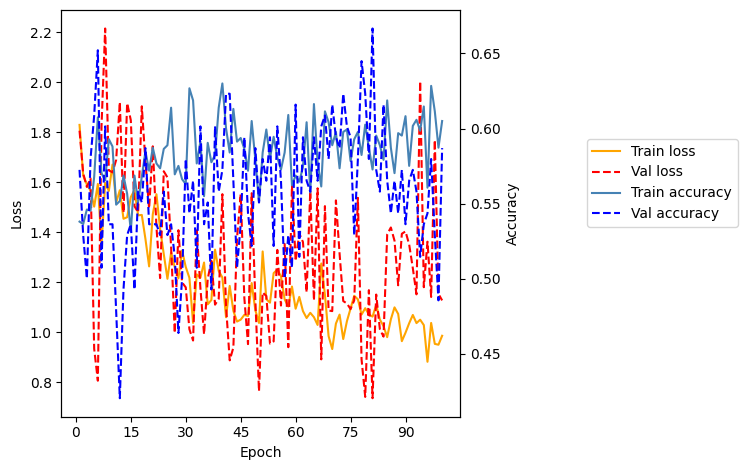

In [44]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt


def plot_training(history: dict, show=True):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    x_range = range(1, len(history["train/loss"]) + 1)  # correct x ticks
    line1 = ax1.plot(x_range, history["train/loss"], color="orange", label="Train loss")
    line2 = ax1.plot(
        x_range, history["val/loss"], color="red", linestyle="dashed", label="Val loss"
    )

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    line3 = ax2.plot(
        x_range, history["train/acc"], color="steelblue", label="Train accuracy"
    )
    line4 = ax2.plot(
        x_range,
        history["val/acc"],
        color="blue",
        linestyle="dashed",
        label="Val accuracy",
    )

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    fig.tight_layout()
    # Shrink current axis by 20%
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lines = line1 + line2 + line3 + line4
    legend_labels = [l.get_label() for l in lines]
    ax1.legend(lines, legend_labels, loc="upper left", bbox_to_anchor=(1.3, 0.7))

    fig.savefig(f"discocat_training.pdf")
    if show:
        fig.show()


plot_training(log["history"])

It can be seen that DisCoCat struggles to converge even after 100 epochs. 